# Classifying Patient Notes as Diabetic

Interesting article:
https://www.cityofhope.org/blog/taking-diabetes-seriously-key-symptoms-that-cannot-be-ignored

In [1]:
import numpy as np
import pandas as pd
import random
import json

In [2]:
NoteEvents = pd.read_csv('NOTEEVENTS.csv')
Admissions = pd.read_csv('ADMISSIONS.csv')

c:\users\ian\appdata\local\programs\python\python36\lib\site-packages\IPython\core\interactiveshell.py:3018: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
data = pd.read_csv('masterPatient.csv', usecols=['hadm_id','diabeties code'])

In [4]:
with open('num_visits_lib.txt') as f:
    Num_Visits_Lib = json.load(f)

The notes that I would like to classify are only patients who have at least 1 instance of diagnosed diabetes. For now, I am only observing patients with two recorded visits and notes that fall under nursing, physician, or discharge. The reason I only want to observe these three notes is they seem to be the best snapshot of the patients overall health/condition. 

In [5]:
v2 = []
for key,val in Num_Visits_Lib.items():  
    if(val == 2):
        v2.append(key)

In [52]:
data_list=[]
for index,row in data.iterrows():
    data_list.append(row['hadm_id'])

In [54]:
patients = []
for index,row in Admissions.iterrows():
    if((str(row['SUBJECT_ID']) in v2) & (row['HADM_ID'] in data_list)):
        patients.append(row['HADM_ID'])

In [56]:
notes = {}
cat = ['Nursing','Physician ','Discharge summary']

for index, row in NoteEvents.iterrows():
    if((row['HADM_ID'] in patients) & (row['CATEGORY'] in cat)):
        notes.setdefault(int(row['HADM_ID']), []).append(row['TEXT'])

In [57]:
with open('notes.txt', 'w') as f:
        json.dump(notes, f)

In [117]:
with open ('notes.txt') as f:
    notes = json.load(f)

Shortening the notes dictionary to make runtime much quicker

In [118]:
selectedNotes = list() 

x=0

for (key, value) in notes.items():
    if x>2000:
        selectedNotes.append(key)
    x=x+1

for key in selectedNotes:
    if key in notes:
        del notes[key]

    

The length of the notes represents the amount of patient visits that fit into the above criteria

In [119]:
print(len(notes))

1034


In [9]:
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras import layers
from keras.preprocessing.text import Tokenizer

Using TensorFlow backend.


This pre-processing step consist of serperating the input and output training and testing data. The text array represents the input, where text classification is the goal. The diabetic array is used to classify the patient as true or false (has diabetes or does not have diabetes).

In [120]:
text = []
diabetic = []

x = 0
for key, value in notes.items():
    patient = key
    text_occ = []
    text_occ = value
    for occ in text_occ:
        text.append(occ)
        for index,row in data.iterrows():
            if(int(patient) == row['hadm_id']):
                diabetic.append(row['diabeties code'])
    x=x+1
    if(x%50 == 0):
        print(x)

    
    

50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000


In [121]:
print(len(text))
print(len(diabetic))

8296
8296


In [122]:
with open('text.txt', 'w') as f:
        json.dump(text, f)

In [123]:
with open('diabetic.txt', 'w') as f:
        json.dump(diabetic, f)

In [124]:
x_train,x_test,y_train,y_test = train_test_split(text,diabetic,
                                                 test_size=0.25,
                                                random_state=1000)

In [125]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(x_train)

In [126]:
X_train = tokenizer.texts_to_sequences(x_train)
X_test = tokenizer.texts_to_sequences(x_test)

vocab_size = len(tokenizer.word_index) + 1

In [127]:
from keras.preprocessing.sequence import pad_sequences

In [128]:
maxlen = 5000
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [129]:
#print(X_train[99,:])

In [130]:
embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 5000, 50)          1656500   
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 50)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 11        
Total params: 1,657,021
Trainable params: 1,657,021
Non-trainable params: 0
_________________________________________________________________


Samples (notes) | Training accuracy | Testing accuracy

75 &nbsp; | &nbsp; 0.6537 &nbsp; | &nbsp; 0.5641

200 &nbsp; | &nbsp;  0.9154 &nbsp;  | &nbsp;  0.7879

500 &nbsp; | &nbsp;  0.9617 &nbsp;  |&nbsp;  0.8656

1034 (1656500 param #) &nbsp; | &nbsp; .9780 &nbsp; | &nbsp; 0.8872 




Training Accuracy: 0.9780
Testing Accuracy:  0.8872


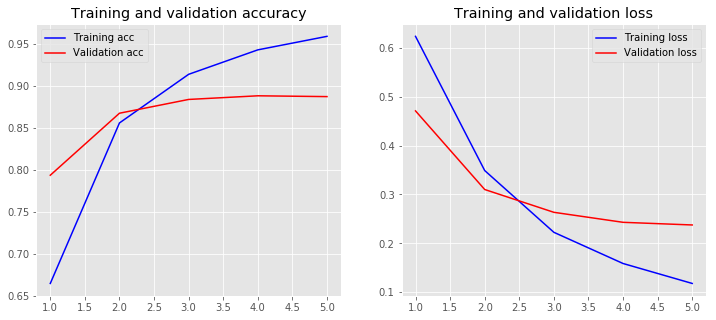

In [131]:
history = model.fit(X_train, y_train,epochs=5
                    ,verbose=False,
                    validation_data=(X_test, y_test),batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

In [142]:
from sklearn.metrics import confusion_matrix

In [148]:
predictions = model.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[ 805,  124],
       [ 110, 1035]], dtype=int64)

In [133]:
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
import eli5
from eli5.sklearn import PermutationImportance

In [ ]:
def base_model():
    model = Sequential()        
    model = Sequential()
    model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
    model.add(layers.GlobalMaxPool1D())
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
    return model

X = X_train
y = y_train

my_model = KerasRegressor(build_fn=base_model)    
my_model.fit(X,y)

perm = PermutationImportance(my_model, random_state=1).fit(X,y)
eli5.show_weights(perm, feature_names = X.columns.tolist())

In [77]:
import matplotlib.pyplot as plt

In [78]:
plt.style.use('ggplot')
def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()